<a href="https://colab.research.google.com/github/667029/KVP10k/blob/main/Relation_Link_layer_LayoutMvl3_KVP10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets torch transformers accelerate numpy tqdm tensorflow scikit-learn

In [ ]:
# Definerer drive lokasjon
drive_mount_path='/content/drive'

In [ ]:
hidden_size = 768           # Size of the hidden vectors.
batch_size = 32             # Batch size.
test_size_percentage = 10   # Percentage of dataset to be dedicated to test
seed = 42                   # Seed for reproducibility.

In [ ]:
import torch
from datasets import load_from_disk
import tensorflow as tf
import numpy as np


class DataUtil:
    @staticmethod
    def get_output(dataset_path=None, model_output=None, drive_mount_path=drive_mount_path, extract_hidden=False, verbose=True):
        if dataset_path is not None:
            try:
                from google.colab import drive
                drive.mount(drive_mount_path, force_remount=False)
            except Exception as e:
                if verbose:
                    print("Google Drive may already be mounted. Continuing...")
            dataset = load_from_disk(dataset_path)
            if verbose:
                print("Loaded dataset from drive.")
                print("Number of samples:", len(dataset))
                print("Column names:", dataset.column_names)
                print("First sample:", dataset[0])
            return dataset
        elif model_output is not None:
            if extract_hidden:
                if isinstance(model_output, dict) and "hidden_states" in model_output:
                    model_output = model_output["hidden_states"]
                elif isinstance(model_output, (list, tuple)):
                    model_output = model_output[-1]
            if verbose:
                print("Provided model output:")
                print(model_output)
            return model_output
        else:
            raise ValueError("Please provide either a dataset_path or a model_output.")

    @staticmethod
    def to_tf_dataset(dataset, hidden_size, batch_size=32, shuffle_buffer=1000, verbose=True):
        def generator():
            for sample in dataset:
                h_i = np.array(sample["h_i"], dtype=np.float32)
                h_j = np.array(sample["h_j"], dtype=np.float32)
                label_arr = np.array(sample["label"], dtype=np.int32)
                label = label_arr[0] if label_arr.ndim > 0 else label_arr
                key = sample["key"] if "key" in sample else "unknown"
                yield (h_i, h_j, label, key)

        first_sample = dataset[0]
        h_i_first = np.array(first_sample["h_i"], dtype=np.float32)

        if h_i_first.ndim == 1:
            output_signature = (
                tf.TensorSpec(shape=(hidden_size,), dtype=tf.float32),
                tf.TensorSpec(shape=(hidden_size,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(), dtype=tf.string),
            )
            ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
            ds = ds.shuffle(shuffle_buffer).batch(batch_size)
        elif h_i_first.ndim == 2:
            output_signature = (
                tf.TensorSpec(shape=(None, hidden_size), dtype=tf.float32),
                tf.TensorSpec(shape=(None, hidden_size), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(), dtype=tf.string),
            )
            ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
            ds = ds.shuffle(shuffle_buffer).padded_batch(
                batch_size,
                padded_shapes=([None, hidden_size], [None, hidden_size], [], [])
            )
        else:
            raise ValueError("Expected h_i to be 1D or 2D; got shape " + str(h_i_first.shape))

        if verbose:
            print(f"Converted dataset to tf.data.Dataset with batch size {batch_size}.")
        return ds



In [ ]:
# 1. # Hent dataset fra drive
# Paths to your datasets
train_dataset_path = "/content/drive/MyDrive/RE_ready/re_dataset_train_combined"
test_dataset_path = "/content/drive/MyDrive/RE_ready/re_dataset_test_combined"

# Load training dataset
train_loaded_dataset = DataUtil.get_output(dataset_path=train_dataset_path)
# Split into train/eval sets (e.g., 90% train, 10% eval)
split_dataset = train_loaded_dataset.train_test_split(test_size=test_size_percentage/100, seed=seed)

# Explicitly naming sets
train_dataset_hf = split_dataset["train"]
eval_dataset_hf = split_dataset["test"]

# Load your separate test dataset for inference/evaluation
test_loaded_dataset = DataUtil.get_output(dataset_path=test_dataset_path)
test_dataset_hf = test_loaded_dataset



# 2. # Hent dataset fra output av layoutmvl3 modellen
# model_output = outputs
# dataset = DataUtil.save_output_as_dataset(model_output=model_output, verbose=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading dataset from disk:   0%|          | 0/35 [00:00<?, ?it/s]

Loaded dataset from drive.
Number of samples: 1411110
Column names: ['h_i', 'h_j', 'label']
First sample: {'h_i': [0.08819432556629181, 0.11771385371685028, -0.13484816253185272, -0.3929871618747711, 0.7269824743270874, 0.22924068570137024, 0.21258839964866638, 0.46119824051856995, -0.008485310710966587, -0.09344914555549622, 0.013197416439652443, -0.07395169138908386, -0.04165968298912048, -0.012204332277178764, -0.03786215931177139, -0.5777946710586548, 0.2996143400669098, -0.14252962172031403, -0.6251698136329651, 0.19645977020263672, 0.24734942615032196, -0.42366012930870056, 0.10904641449451447, -0.08125343918800354, 0.23178817331790924, -0.43984630703926086, 0.616330623626709, -0.4597790241241455, -0.234318345785141, 0.20567676424980164, -0.585768461227417, -0.10556289553642273, -0.6416462659835815, 0.026363598182797432, -0.5135732889175415, -0.11054161936044693, 0.4881322383880615, -0.242694690823555, -0.061750371009111404, -0.14020699262619019, 0.04512529447674751, -0.108396925

In [ ]:
import numpy as np
import tensorflow as tf

# Oppretter trening og test set
train_dataset = DataUtil.to_tf_dataset(train_dataset_hf, hidden_size=hidden_size, batch_size=32)
for batch in train_dataset.take(1):
    h_i_batch, h_j_batch, labels_batch, keys_batch = batch
    print("h_i batch shape:", h_i_batch.shape)
    print("h_j batch shape:", h_j_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print("keys batch shape:", keys_batch.shape)

test_dataset = DataUtil.to_tf_dataset(test_dataset_hf, hidden_size=hidden_size, batch_size=32)
for batch in test_dataset.take(1):
    h_i_batch, h_j_batch, labels_batch, keys_batch = batch
    print("h_i batch shape:", h_i_batch.shape)
    print("h_j batch shape:", h_j_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print("keys batch shape:", keys_batch.shape)

Converted dataset to tf.data.Dataset with batch size 32.
h_i batch shape: (32, 768)
h_j batch shape: (32, 768)
labels batch shape: (32,)
keys batch shape: (32,)
Converted dataset to tf.data.Dataset with batch size 32.
h_i batch shape: (32, 768)
h_j batch shape: (32, 768)
labels batch shape: (32,)
keys batch shape: (32,)


In [ ]:
import numpy as np
import tensorflow as tf

class Bilinear(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_relations):
        super(Bilinear, self).__init__()
        self.hidden_size = hidden_size
        self.num_relations = num_relations

    def build(self, input_shape):
        # Create weight tensor of shape (hidden_size, num_relations, hidden_size)
        self.W = self.add_weight(
            shape=(self.hidden_size, self.num_relations, self.hidden_size),
            initializer='glorot_uniform',
            trainable=True,
            name="bilinear_W"
        )
        # Bias vector of shape (num_relations,)
        self.bias = self.add_weight(
            shape=(self.num_relations,),
            initializer='zeros',
            trainable=True,
            name="bilinear_bias"
        )
        super(Bilinear, self).build(input_shape)

    def call(self, inputs):
        head, tail = inputs  # Both are (batch, hidden_size)
        # Use einsum to compute: for each sample, head^T * W * tail.
        # Equation: 'bi,irk,bj->br' where:
        #   b: batch, i: hidden dimension from head, j: hidden dimension from tail, r: relation index.
        logits = tf.einsum('bi,irk,bj->br', head, self.W, tail)
        logits = logits + self.bias
        return logits

In [ ]:
import tensorflow as tf

# Define the relation extraction model as a subclass of tf.keras.Model.
class RelationExtractionHead(tf.keras.Model):
    def __init__(self, hidden_size, num_relations):
        super(RelationExtractionHead, self).__init__()
        self.head_proj = tf.keras.layers.Dense(hidden_size, name="head_proj")
        self.tail_proj = tf.keras.layers.Dense(hidden_size, name="tail_proj")
        self.bilinear = Bilinear(hidden_size, num_relations)

    def call(self, inputs, training=False):
        h_i, h_j = inputs  # both are (batch, hidden_size)
        head = self.head_proj(h_i)
        tail = self.tail_proj(h_j)
        logits = self.bilinear((head, tail))  # (batch, num_relations)
        return logits

Epoch 1/1, sampling 1212940 examples...


Epoch 1: 100%|██████████| 37905/37905 [3:04:22<00:00,  3.43batch/s]


Epoch 1, Average Loss: 39.6414


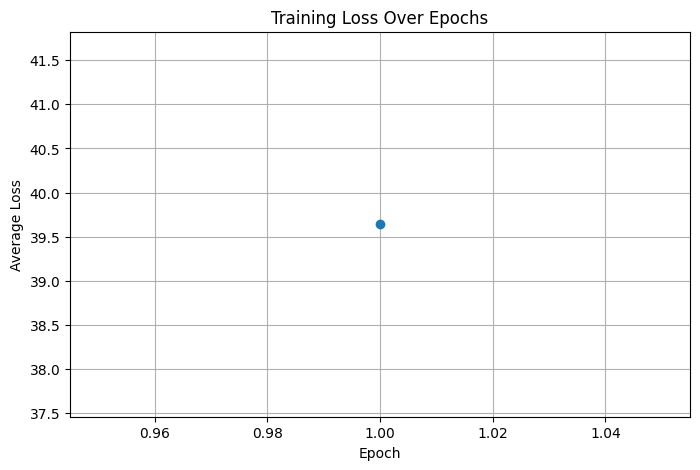

In [ ]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

# Hyperparameters
num_relations = 5
num_epochs = 1
learning_rate = 1e-4
num_train_samples = len(train_dataset_hf)
sample_base = int(np.ceil(num_train_samples / num_epochs))
sample_range_min = int(sample_base * 0.95)
sample_range_max = int(sample_base * 1.10)

# Model and optimizer
model_tf = RelationExtractionHead(hidden_size=hidden_size, num_relations=num_relations)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_history = []

for epoch in range(num_epochs):
    samples_this_epoch = random.randint(sample_range_min, sample_range_max)
    total_batches = int(np.ceil(samples_this_epoch / batch_size))

    epoch_dataset = (
        train_dataset.unbatch()
        .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
        .take(samples_this_epoch)
        .batch(batch_size)
    )

    print(f"Epoch {epoch+1}/{num_epochs}, sampling {samples_this_epoch} examples...")
    epoch_loss = []

    for batch, (h_i_batch, h_j_batch, labels_batch, keys_batch) in enumerate(tqdm(epoch_dataset, total=total_batches, desc=f"Epoch {epoch+1}", unit="batch")):
        if len(h_i_batch.shape) == 3:
            h_i_batch = tf.reduce_mean(h_i_batch, axis=1)
            h_j_batch = tf.reduce_mean(h_j_batch, axis=1)

        with tf.GradientTape() as tape:
            logits = model_tf((h_i_batch, h_j_batch), training=True)
            loss = loss_fn(labels_batch, logits)

        grads = tape.gradient(loss, model_tf.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_tf.trainable_variables))
        epoch_loss.append(loss.numpy())

    avg_loss = np.mean(epoch_loss)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import tensorflow as tf

class RelationModelTesterTF:
    def __init__(self, model, dataset, batch_size=32, num_samples=None):
        self.model = model
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_samples = num_samples or sum(1 for _ in dataset)
        self.total_batches = int(np.ceil(self.num_samples / batch_size))

    def evaluate(self):
        all_predictions = []
        all_ground_truths = []
        all_probabilities = []
        all_keys = []
        all_h_i = []
        all_h_j = []

        progress_bar = tqdm(self.dataset, desc="Evaluating", unit="batch", total=self.total_batches)

        for h_i_batch, h_j_batch, labels_batch, keys_batch in progress_bar:
            # Pool if necessary
            if len(h_i_batch.shape) == 3:
                h_i_pooled = tf.reduce_mean(h_i_batch, axis=1)
                h_j_pooled = tf.reduce_mean(h_j_batch, axis=1)
            else:
                h_i_pooled = h_i_batch
                h_j_pooled = h_j_batch

            logits = self.model((h_i_pooled, h_j_pooled), training=False)
            probabilities = tf.nn.softmax(logits, axis=-1)
            predictions = tf.argmax(probabilities, axis=-1)

            all_predictions.extend(predictions.numpy())
            all_ground_truths.extend(labels_batch.numpy())
            all_probabilities.extend(probabilities.numpy())
            all_keys.extend(keys_batch.numpy())
            all_h_i.extend(h_i_pooled.numpy())
            all_h_j.extend(h_j_pooled.numpy())

        accuracy = np.mean(np.array(all_predictions) == np.array(all_ground_truths))
        return {
            "predictions": all_predictions,
            "ground_truth": all_ground_truths,
            "accuracy": accuracy,
            "probabilities": all_probabilities,
            "keys": all_keys,
            "h_i": all_h_i,
            "h_j": all_h_j
        }

In [ ]:
# Convert the test split to a stable, properly batched tf.data.Dataset
# Now pass the test dataset to the tester
tester = RelationModelTesterTF(model_tf, test_dataset, batch_size=32, num_samples=len(test_dataset_hf))
results = tester.evaluate()

print("Test Accuracy: {:.2f}%".format(results["accuracy"] * 100))
print("Example Predictions (first 10 samples):", results["predictions"][:10])

# Print out predictions and labels
print("Sample-wise Predictions:")
for i in range(min(10, len(results["predictions"]))):
    print(f"\nSample {i}")
    print("True Label      :", results["ground_truth"][i])
    print("Predicted Label :", results["predictions"][i])
    print("Probabilities   :", np.round(results["probabilities"][i], 4))
    print("h_i (first 5)   :", np.round(results["h_i"][i][:5], 4))
    print("h_j (first 5)   :", np.round(results["h_j"][i][:5], 4))

Evaluating: 100%|██████████| 4484/4484 [04:22<00:00, 17.10batch/s]

Test Accuracy: 97.97%
Example Predictions (first 10 samples): [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Sample-wise Predictions:

Sample 0 (Key: b'unknown')
True Label      : 1
Predicted Label : 1
Probabilities   : [0. 1. 0. 0. 0.]
h_i (first 5)   : [-0.5675  0.4291 -0.0777 -0.1935  1.1557]
h_j (first 5)   : [-0.5523  0.2321 -0.3532 -0.8369  1.8179]

Sample 1 (Key: b'unknown')
True Label      : 1
Predicted Label : 1
Probabilities   : [0. 1. 0. 0. 0.]
h_i (first 5)   : [-0.5944 -0.0955 -0.0611 -0.0304  1.7765]
h_j (first 5)   : [-0.3277  1.0899 -0.2359 -0.3746  1.9394]

Sample 2 (Key: b'unknown')
True Label      : 1
Predicted Label : 1
Probabilities   : [0. 1. 0. 0. 0.]
h_i (first 5)   : [-0.4906 -0.4914  0.1082  0.4006  2.7536]
h_j (first 5)   : [-0.1238 -0.2228  0.2467  0.3643  0.6829]

Sample 3 (Key: b'unknown')
True Label      : 1
Predicted Label : 1
Probabilities   : [0. 1. 0. 0. 0.]
h_i (first

In [ ]:
import os

OCR_JSON_DIR = "/content/drive/Shareddrives/SomeSharedDrive/KVP10K/test/ocrs"

print("Exists:", os.path.exists(OCR_JSON_DIR))
print("Is Dir:", os.path.isdir(OCR_JSON_DIR))
print("Files:", os.listdir(OCR_JSON_DIR)[:5] if os.path.exists(OCR_JSON_DIR) else "Not found")


Exists: False


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/KVP10K-dataset/kvp10k/test/ocrs'

In [43]:
import os
import json
from datasets import load_from_disk
from collections import defaultdict
from itertools import islice

# === CONFIG ===
OCR_JSON_DIR = '/content/drive/MyDrive/KVP10K-dataset/kvp10k/test/ocrs'
rel_ds = test_loaded_dataset

# Map integer label → relation name
ID2REL = {
    0: 'no_relation',
    1: 'parent_identifier',
    2: 'invoice_date',
    3: 'order_number',
    4: 'sum',
    5: 'customer_name',
}

# --- AGGREGATE TEXTUAL KEY/VALUE PAIRS ---
matches = defaultdict(lambda: defaultdict(list))

# Iterate over the first 100 items
for example, pred_id, prob_dist in islice(zip(rel_ds, results['predictions'], results['probabilities']), 100):
    if 'doc_id' not in example:
        print("Missing 'doc_id' in example:", example)
        continue

    doc_id   = example['doc_id']
    head_idx = example['head_idx']
    tail_idx = example['tail_idx']
    rel_name = ID2REL[pred_id]
    score    = round(float(prob_dist[pred_id]), 4)

    # Load that document's OCR JSON
    ocr_path = os.path.join(OCR_JSON_DIR, f"{doc_id}.json")
    ocr_json = json.load(open(ocr_path, encoding='utf-8'))
    lines    = ocr_json['form']

    # Pull out actual text for head and tail
    key_text   = lines[head_idx]['text']
    value_text = lines[tail_idx]['text']

    # Store
    matches[doc_id][rel_name].append({
        'key': key_text,
        'value': value_text,
        'score': score,
    })

# --- PRINT TOP-SCORING PAIR PER DOC ---
for doc_id, rels in matches.items():
    print(f"\n📄 Document: {doc_id}")
    for rel, items in rels.items():
        best = max(items, key=lambda x: x['score'])
        print(
            f"{rel}: {best['value']}   "
            f"(key='{best['key']}', score={best['score']})"
        )


Missing 'doc_id' in example: {'h_i': [-0.03574247285723686, -0.015568173490464687, 0.04433594271540642, -0.2551768124103546, 0.5431303381919861, -0.052284833043813705, 0.1384091079235077, 0.27487412095069885, -0.17961081862449646, -0.10797158628702164, -0.46370697021484375, -0.14926613867282867, -0.09300041943788528, 0.06408052891492844, 0.12591618299484253, -0.3600463271141052, -0.06332714110612869, -0.20246948301792145, -0.25451621413230896, 0.36145108938217163, -0.012236740440130234, -0.0203297920525074, 0.12791365385055542, -0.06409116834402084, -0.023888980969786644, 0.1217065379023552, 0.14684250950813293, -0.341422438621521, -0.08902009576559067, 0.03113497979938984, -0.3619805574417114, -0.2470576912164688, -0.39857348799705505, -0.16561433672904968, -0.2645741105079651, -0.19168643653392792, 0.04270109906792641, 0.03634512424468994, -0.20749381184577942, -0.2225838303565979, 0.23924097418785095, 0.019254252314567566, 0.27237167954444885, 0.4337293803691864, -0.0862726345658302